In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math

2025-07-15 10:18:10.936853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752567490.958348  244136 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752567490.964850  244136 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752567490.981383  244136 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752567490.981408  244136 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752567490.981412  244136 computation_placer.cc:177] computation placer alr

In [2]:
TRAIN_DATA_DIR = 'data/train/'
VALIDATION_DATA_DIR = 'data/val/'
TRAIN_SAMPLES = 500
VALIDATION_SAMPLES = 500
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

In [3]:
train_datagen =ImageDataGenerator(preprocessing_function=preprocess_input,
rotation_range=20,
width_shift_range=0.2,
height_shift_range=0.2,
zoom_range=0.2)

In [4]:
val_datagen =ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
train_generator = train_datagen.flow_from_directory(
TRAIN_DATA_DIR,
target_size=(IMG_WIDTH, IMG_HEIGHT),
batch_size=BATCH_SIZE,
shuffle=True,
seed=12345,
class_mode='categorical')

Found 500 images belonging to 2 classes.


In [6]:
validation_generator = val_datagen.flow_from_directory(
VALIDATION_DATA_DIR,
target_size=(IMG_WIDTH, IMG_HEIGHT),
batch_size=BATCH_SIZE,
shuffle=False,
class_mode='categorical')

Found 500 images belonging to 2 classes.


In [7]:
def model_maker():
    base_model = MobileNet(include_top=False, input_shape =(IMG_WIDTH,IMG_HEIGHT,3))
    for layer in base_model.layers[:]:
        layer.trainable = False # Freeze the layers
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
model = model_maker()
model.compile(loss='categorical_crossentropy',
optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
metrics=['acc'])
num_steps = math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE)
model.fit(train_generator,
steps_per_epoch = num_steps,
epochs=10,
validation_data = validation_generator,
validation_steps = num_steps)

/home/jangcha/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - acc: 0.6054 - loss: 0.8268 - val_acc: 0.9580 - val_loss: 0.1586
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - acc: 0.9057 - loss: 0.2171 - val_acc: 0.9720 - val_loss: 0.0956
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - acc: 0.9484 - loss: 0.1679 - val_acc: 0.9780 - val_loss: 0.0722
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - acc: 0.9552 - loss: 0.1385 - val_acc: 0.9860 - val_loss: 0.0616
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - acc: 0.9520 - loss: 0.1121 - val_acc: 0.9860 - val_loss: 0.0514
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - acc: 0.9742 - loss: 0.0764 - val_acc: 0.9880 - val_loss: 0.0482
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - acc: 0.9700 - loss: 0.0728 - val_acc: 0.9860 - val_loss: 0.0453
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - acc: 0.9617 - loss: 0.0929 - val_acc: 0.9900 - val_loss: 0.0390
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - acc: 0.9818 - loss: 0.0681 - val_acc: 

In [12]:
model.save('model.h5')

In [16]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
model = load_model('model.h5')

In [17]:
img_path = '/home/jangcha/computer_vision_and_robotics/day-5/data/cat.2.jpg'
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array) # Preprocess the image
prediction = model.predict(preprocessed_img)
print(prediction)
print(validation_generator.class_indices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
[[9.9997187e-01 2.8134924e-05]]
{'cat': 0, 'dog': 1}


In [18]:
# VARIABLES
IMG_WIDTH, IMG_HEIGHT = 224, 224
VALIDATION_DATA_DIR = 'data/val/'
VALIDATION_BATCH_SIZE = 64
# DATA GENERATORS
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(
VALIDATION_DATA_DIR,
target_size=(IMG_WIDTH, IMG_HEIGHT),
batch_size=VALIDATION_BATCH_SIZE,
shuffle=False,
class_mode='categorical')
ground_truth = validation_generator.classes

Found 500 images belonging to 2 classes.


In [19]:
predictions  = model.predict(validation_generator)

/home/jangcha/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 584ms/step


In [37]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


filenames = validation_generator.filenames

In [38]:
def get_images_with_sorted_probabilities(prediction_table,
                                         get_highest_probability,
                                         label,
                                         number_of_items,
                                         only_false_predictions=False):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)
                               ]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]

In [39]:
# prediction_table is a dict with index, prediction, ground truth
prediction_table = {}
for index, val in enumerate(predictions):
# get argmax index
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [value_of_highest_probability,index_of_highest_probability, ground_truth[index]]
assert len(predictions) == len(ground_truth) == len(prediction_table)

In [42]:
import math
def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 15))
    columns = 5
    rows = math.ceil(len(images) / columns)
    for i, image in enumerate(images):
        ax = plt.subplot(rows, columns, i + 1)
        ax.set_title( 
            "\n\n" + filenames[i].split("/")[-1] +
            "\nProbability: " + str(float("{0:.2f}".format(distances[i])))
        )
        plt.imshow(image)
        plt.axis('off')
    plt.suptitle(message, fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()
        
def display(sorted_indices, message):
    similar_image_paths = []
    distances = []
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value
        similar_image_paths.append(VALIDATION_DATA_DIR + filenames[name])
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)

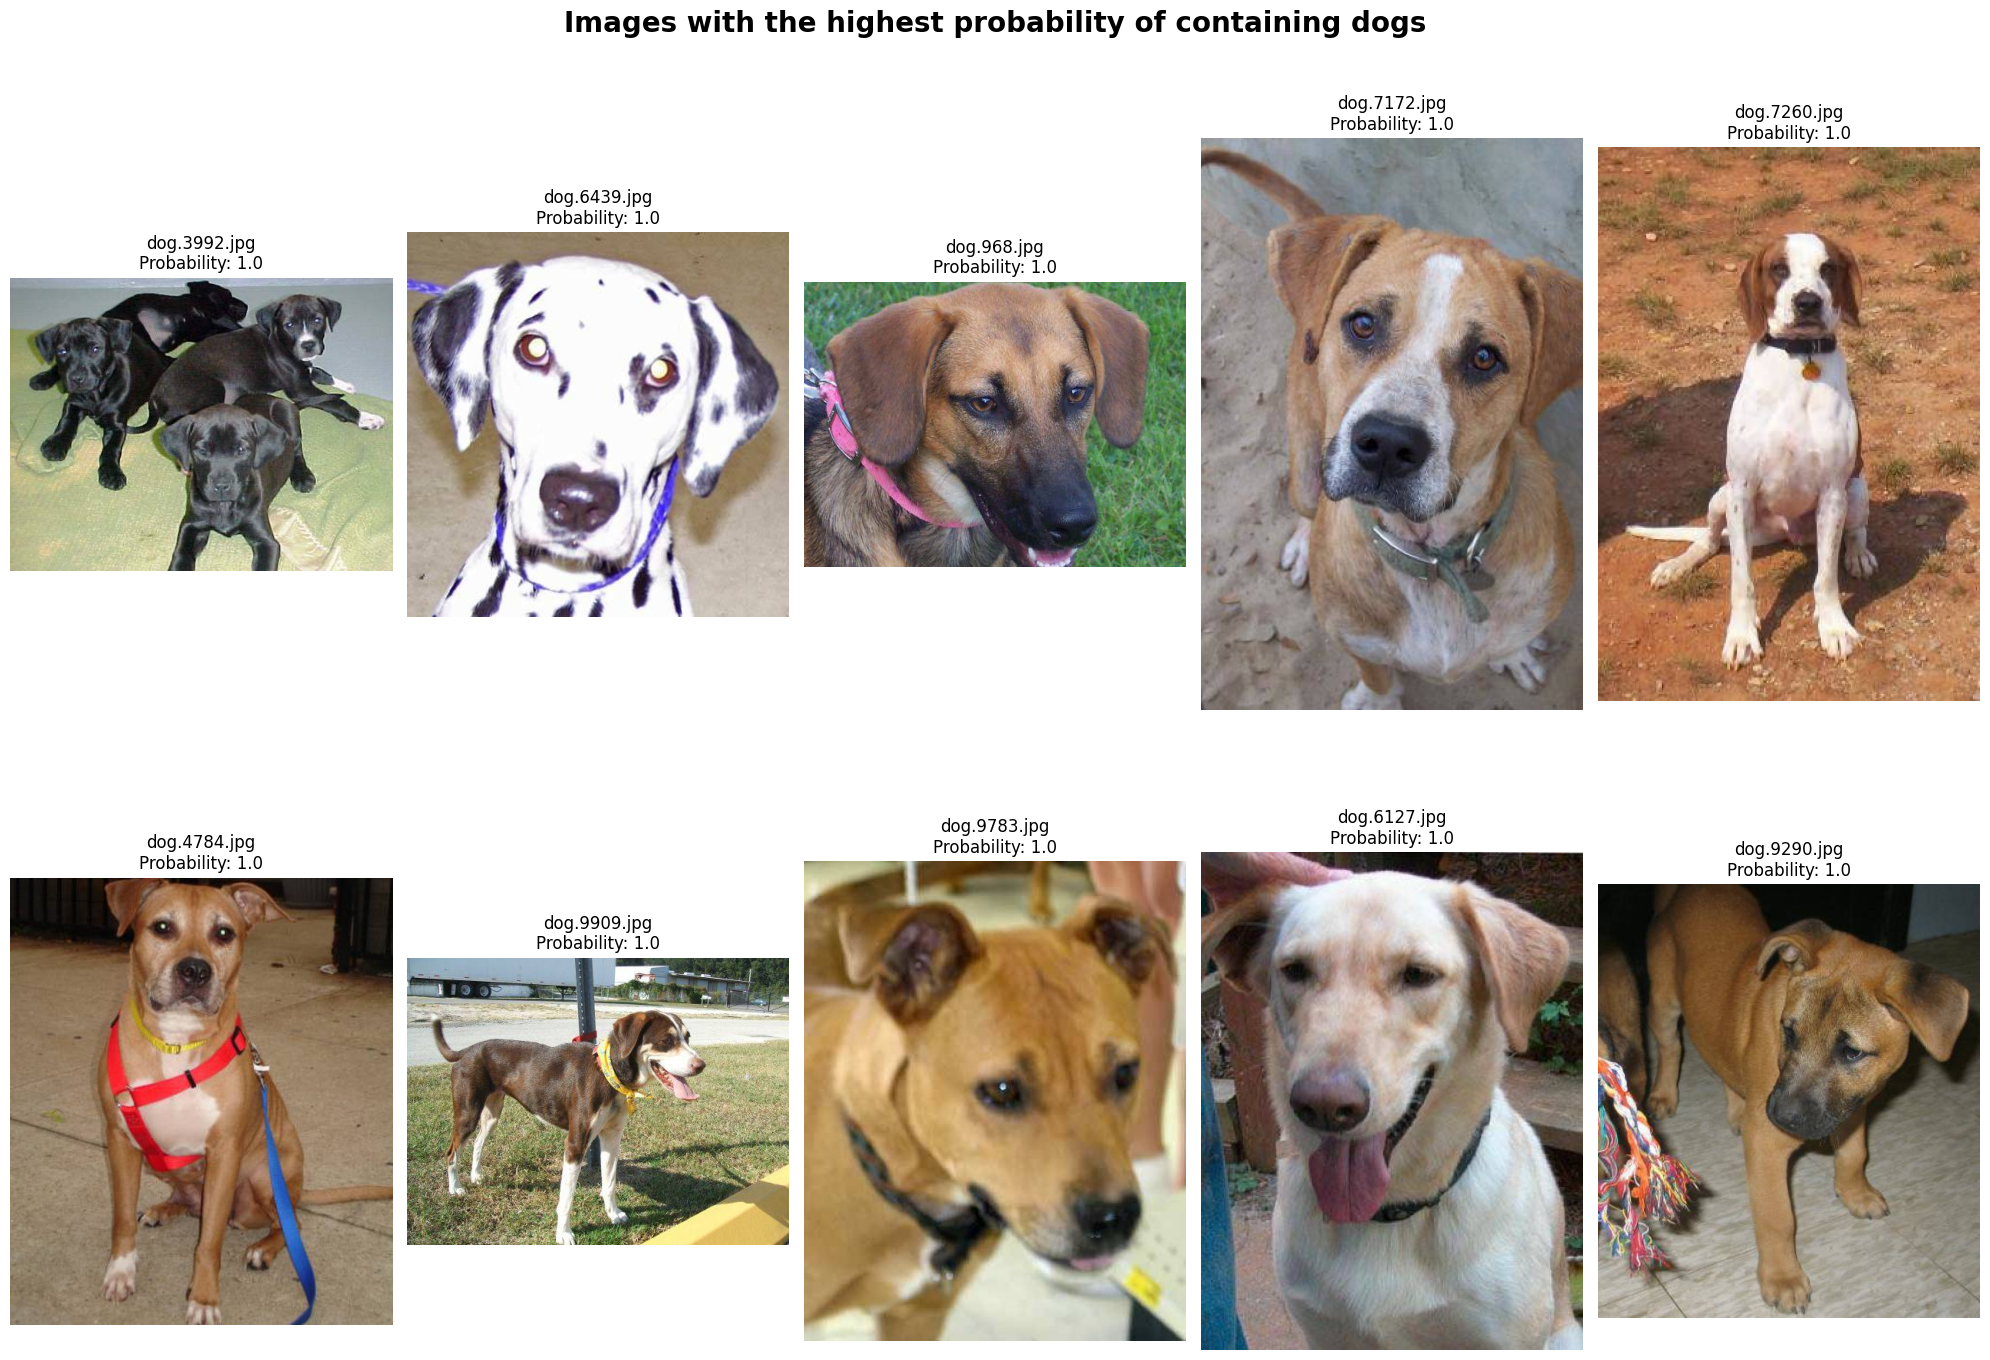

In [43]:
indices = get_images_with_sorted_probabilities(prediction_table,
get_highest_probability=True, label=1, number_of_items=10,
only_false_predictions=False)
message = 'Images with the highest probability of containing dogs'
display(indices[:10], message)

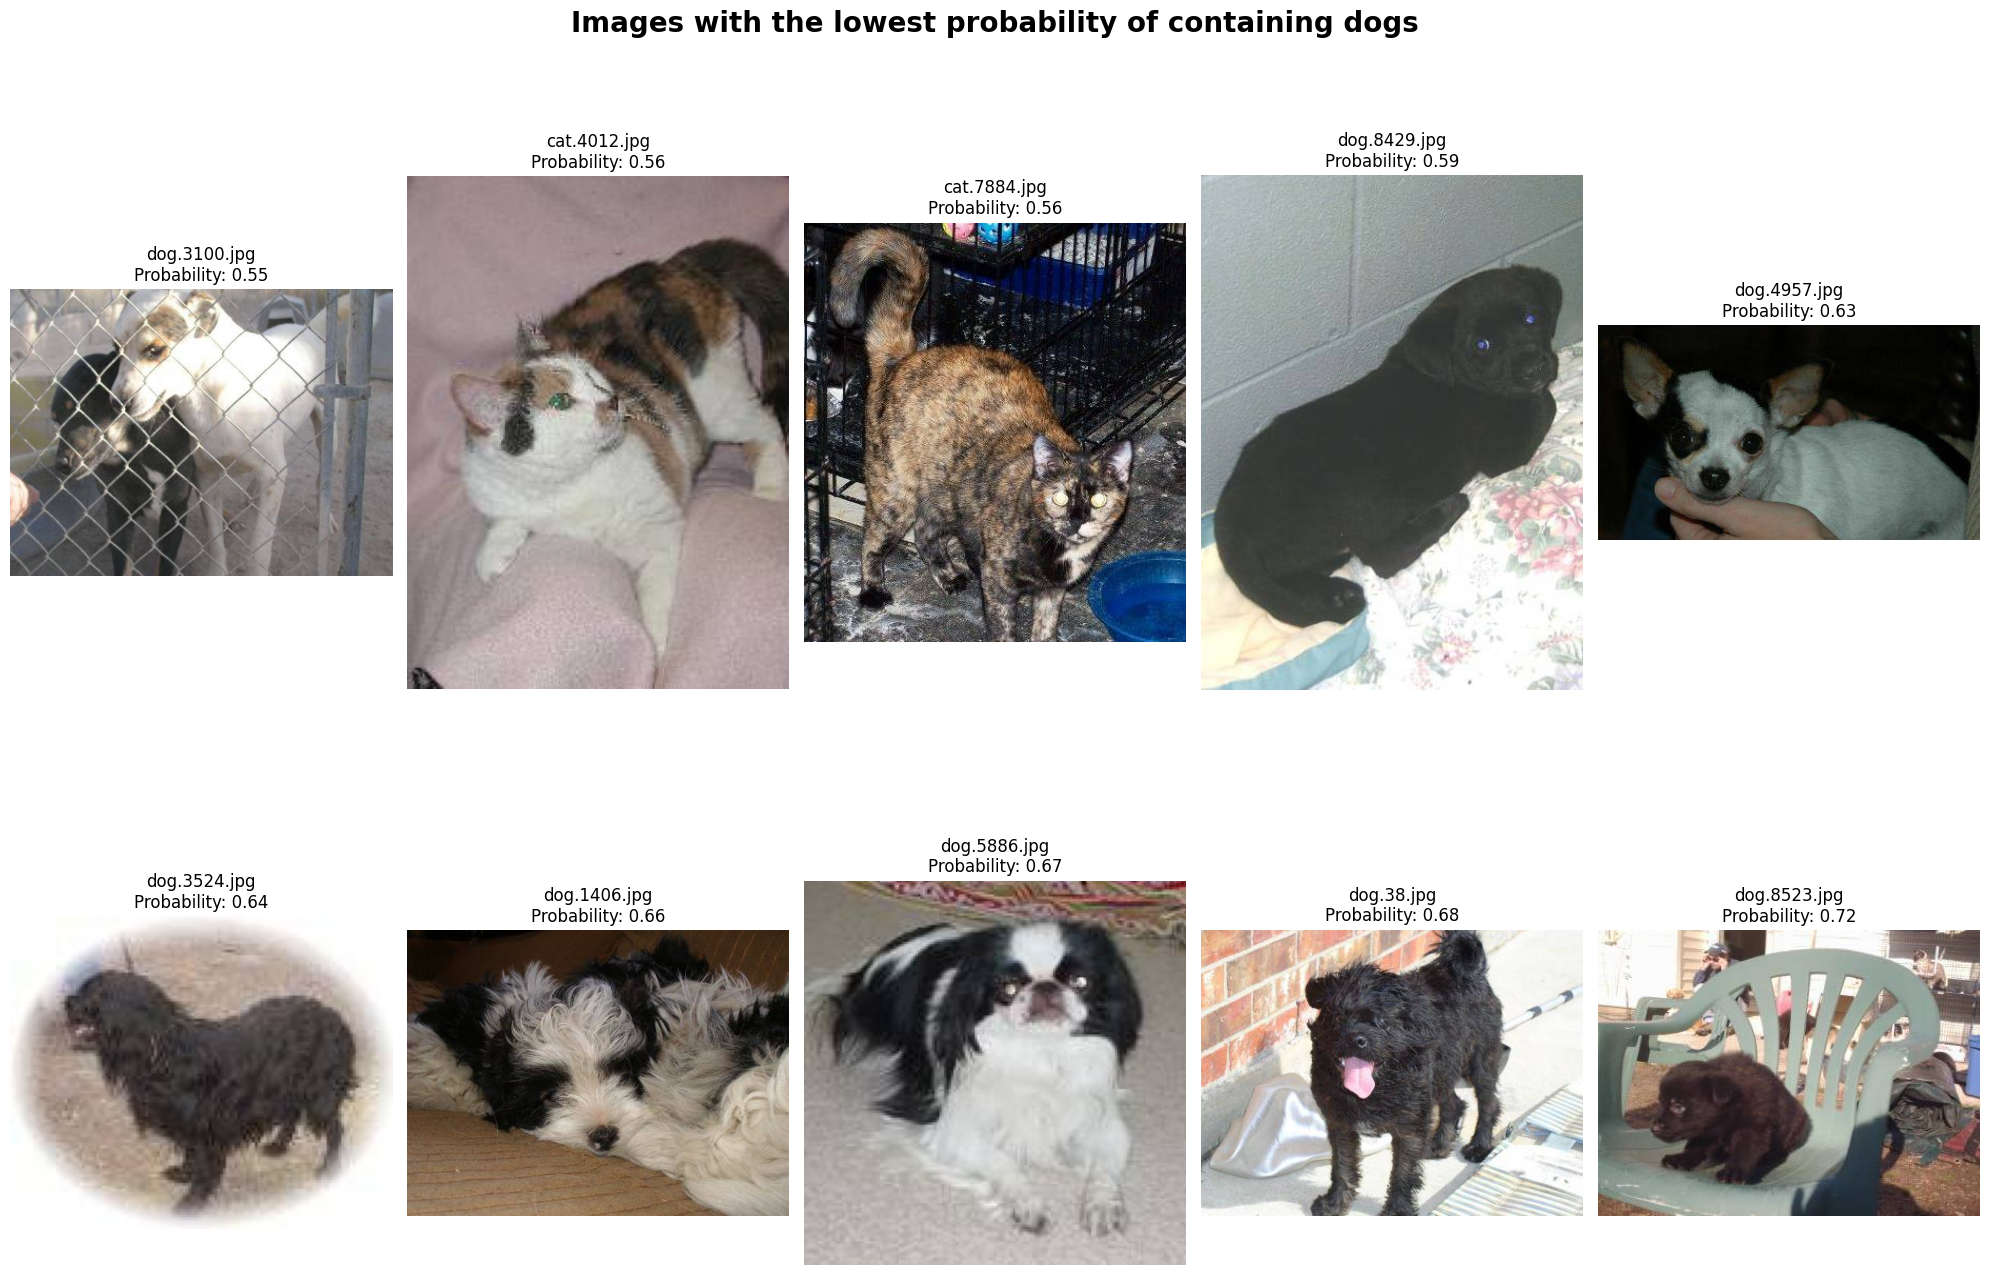

In [44]:
indices = get_images_with_sorted_probabilities(prediction_table,
get_highest_probability=False, label=1, number_of_items=10,
only_false_predictions=False)
message = 'Images with the lowest probability of containing dogs'
display(indices[:10], message)

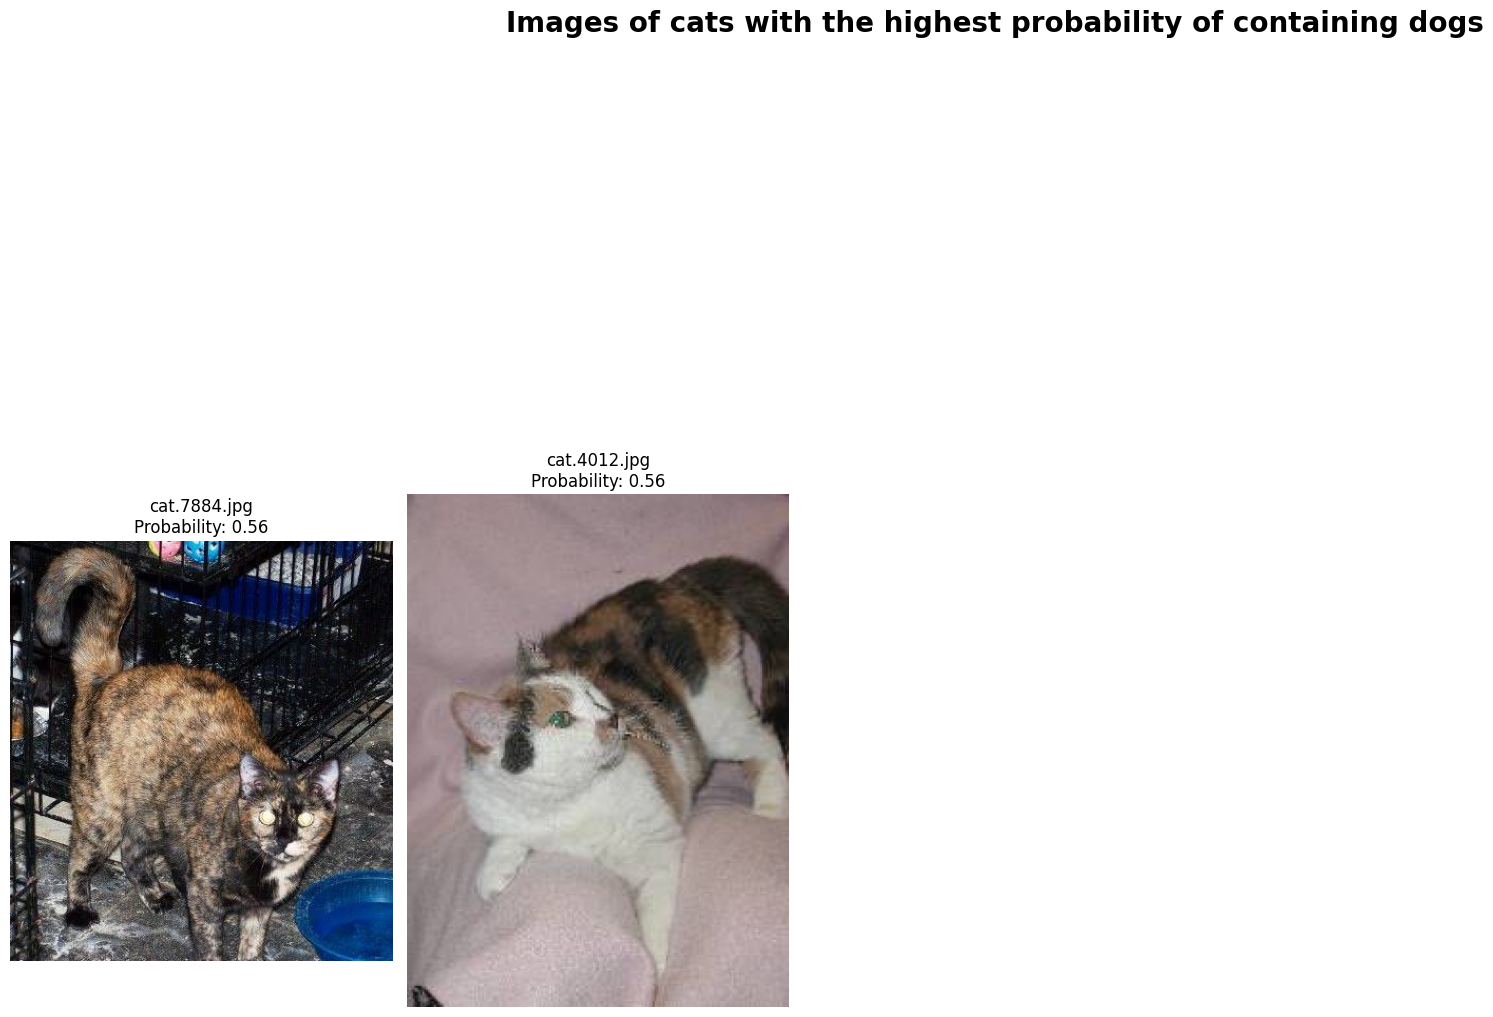

In [46]:
# Incorrect predictions of 'dog'
indices = get_images_with_sorted_probabilities(prediction_table,
get_highest_probability=True, label=1, number_of_items=10,
only_false_predictions=True)
message = 'Images of cats with the highest probability of containing dogs'
display(indices[:10], message)